<a href="https://colab.research.google.com/github/kouskouss/hate_speech_detection_greek/blob/main/7_Hate_speech_detection_with_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers torch

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

In [ ]:
import nltk
nltk.download("stopwords")

# import nltk
nltk.download('wordnet')

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# epeksergasia keimenou - afairesh stopwords!!
# visialisation

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize

# PRE-PROCESSING
import string
from nltk.corpus import stopwords
import spacy
from nltk.tokenize import word_tokenize
import re

def replaceMultiple(main, replacements, new):
    for elem in replacements:
        if elem in main:
            main = main.replace(elem, new)

    return main


def normalize(x):
    x = x.replace('ά', 'α')
    x = x.replace('έ', 'ε')
    x = x.replace('ή', 'η')
    x = replaceMultiple(x, ['ί', 'ΐ', 'ϊ'], 'ι')
    x = x.replace('ό', 'ο')
    x = replaceMultiple(x, ['ύ', 'ΰ', 'ϋ'], 'υ')
    x = x.replace('ώ', 'ω')
    return x

def remove_stopwords(text):
    stop_words = stopwords.words('greek')

    # Tokenize the text into words
    words = word_tokenize(text)

    # Get the English stopwords from NLTK
    # stop_words = set(stopwords.words('english'))  # Use the appropriate language here
    stop_words = set(stopwords.words('greek'))

    # Additional stopwords to be added
    custom_stopwords = {'της', 'την', 'τη', 'μια', 'ενω', 'μας', 'οτι', 'όλοι', 'oλοι', 'ότι', 'είναι', 'ειναι', 'ρε', 'αυτα', 'έχω', 'εχω',
                        'έχεις', 'έχει', 'εχει', 'εισαι', 'είσαι', 'εχεις', 'ησουν', 'ήσουν', 'ειχαν', 'ενα', 'αυτα', 'αυτος', 'εσυ', 'σου', 'μου',
                        'τους', 'του', 'στις', 'σας', 'σα', 'σαν', 'σ’', 'ετσι', 'απο', 'από' 'γιατί', 'γιατι', 'μεχρι', 'απτο', 'αλλο',
                        'τοσο', 'ενας', 'εσενα', 'καποιος', 'πριν', 'ειχε', 'στα', 'ηταν', 'ήταν', 'user', 'οταν'}  # Add your words here

    # Extend the stopwords set with custom stopwords
    stop_words.update(custom_stopwords)

    # Remove stopwords
    filtered_words = [word for word in words if word.lower() not in stop_words]

    # Reconstruct the text without stopwords
    text_without_stopwords = ' '.join(filtered_words)
    return text_without_stopwords



punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

def clean_text(text):
    text = text.lower()
    hashtags = "#[\S]+"
    mentions = "@[\S]+"
    url = "https?://[A-z0-9_%/\-\.]+[A-z0-9_\.\-\?&=%]+"
    text = re.sub(url,"",text)
    text = re.sub(hashtags,"",text)
    text = re.sub(mentions,"",text)
    puntuations = "[\.\?!,;:]+"
    text = re.sub(puntuations,"",text)
    return text


def text_processing(text):
    text = remove_stopwords(text) #diwxnw stopwords - gt periexoun tonous ayta k met diwxnw tonous
    text = normalize(text)  #diwxnw tonous
    text = text.lower() #ola mikra
    text = remove_punctuations(text) #diwxnw punctiations

    return text

## hate/ non hate dataset

In [ ]:
import pandas as pd
import numpy as np

# Replace 'your_file.csv' with the path to your CSV file
csv_file = 'CHATGPT TWEETS_nolinks.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(csv_file)

# # Extract the unique values from the second column (assuming it's named 'column_name')
# unique_values = df['class'].unique()

# # Print the unique values
# for value in unique_values:
#     print(value)


# Replace empty strings with NaN
df['class'] = df['class'].replace(' ', np.nan)
df = df[['Tweet', 'class']]
# Filter rows where the second column (assuming it's named 'column_name') is not NaN
filtered_df = df[df['class'].notna()]
df=filtered_df
df['class']=df['class'].astype(int)
df=df.reset_index(drop=True)
# df = df[['Tweet', 'class']]

In [ ]:
df

,Tweet,class
0,Η απορία της ημέρας!!\n\nΓιατί σε φωτογραφία π...,0
1,Ρε κόψτε την σύνδεση με τον βλακα Καραγιάννη έ...,1
2,Ότι ήσουν μαλάκω το ξέραμε. Ότι ήσουν αμπαλη ...,1
3,ΠΟΙΟΣ ΓΑΜΙΟΛΗΣ ΚΡΥΒΕΤΑΙ ΠΙΣΩ ΑΠΤΗΝΕ ΑΝΑΠΑΤΕΧΗ ...,1
4,Βλεπω αυτόν τον πατέρα στην Σκατιανα και μου έ...,1
...,...,...
551,Μου αρέσει που σου μιλάνε στον πληθυντικό ρ...,1
552,Δεν έχει άλλα λόγια για να τον χαρακτηρίσει ο ...,1
553,"Αν κ δε βλέπω να μιλάς σοβαρά, θα το προσπαθή...",0
554,Όλη η #Γαλλια ειναι μια εμπολεμη ζώνη! Και όλο...,0


# VISUALISATION DATA HAT/NON HATE


In [ ]:
df_visualisation = df
df_visualisation['Tweet'] = df_visualisation['Tweet'].apply(lambda x: text_processing(x))
df_visualisation['Tweet'] = df_visualisation['Tweet'].apply(lambda x: clean_text(x))

visualisation arxika

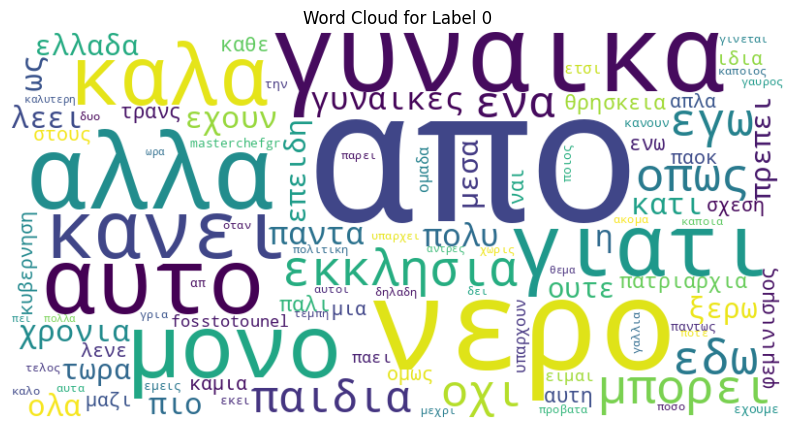

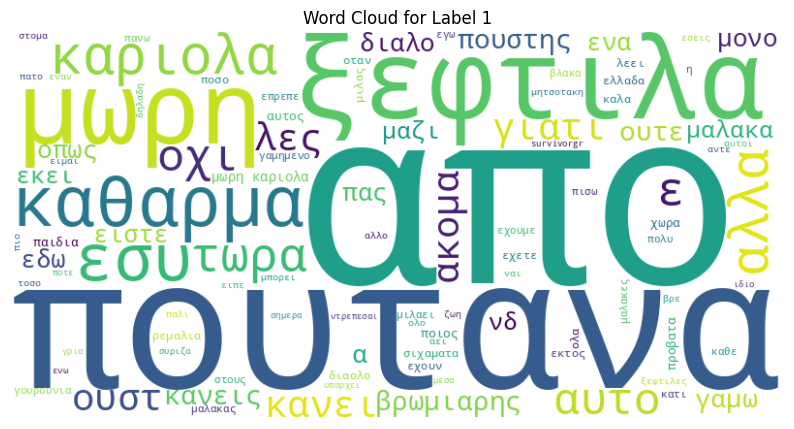

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
import pandas as pd


# Text preprocessing function
def preprocess_text(text):
    stop_words = set(stopwords.words('english'))  # Choose the appropriate language
    text = text.lower()  # Convert text to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize the text
    filtered_tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return ' '.join(filtered_tokens)

# Concatenate tweets based on their label
tweets_per_label = {label: '' for label in df_visualisation['class'].unique()}
for index, row in df_visualisation.iterrows():
    label = row['class']
    tweets_per_label[label] += ' ' + preprocess_text(row['Tweet'])

# Create WordCloud for each label
for label, text in tweets_per_label.items():
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Label {label}')
    plt.axis('off')
    plt.show()


## multi-label dataset

In [ ]:
import pandas as pd
import numpy as np

df_multi = pd.read_csv('CHATGPT TWEETS_nolinks.csv')

# ekei pou to 'class' den einai nan - oxi me ta perissotera  labels
df_multi = df_multi[:4400]

# Replace empty strings with NaN
df_multi['category'] = df_multi['category'].replace(' ', np.nan)
df_multi = df_multi[['Tweet', 'category']]
# Filter rows where the second column (assuming it's named 'column_name') is not NaN
filtered_df_multi = df_multi[df_multi['category'].notna()]
df_multi=filtered_df_multi
df_multi['category']=df_multi['category'].astype(int)
df_multi=df_multi.reset_index(drop=True)
df_multi

,Tweet,category
0,Η απορία της ημέρας!!\n\nΓιατί σε φωτογραφία π...,0
1,Ρε κόψτε την σύνδεση με τον βλακα Καραγιάννη έ...,1
2,Ότι ήσουν μαλάκω το ξέραμε. Ότι ήσουν αμπαλη ...,2
3,ΠΟΙΟΣ ΓΑΜΙΟΛΗΣ ΚΡΥΒΕΤΑΙ ΠΙΣΩ ΑΠΤΗΝΕ ΑΝΑΠΑΤΕΧΗ ...,3
4,Βλεπω αυτόν τον πατέρα στην Σκατιανα και μου έ...,3
...,...,...
551,Μου αρέσει που σου μιλάνε στον πληθυντικό ρ...,1
552,Δεν έχει άλλα λόγια για να τον χαρακτηρίσει ο ...,1
553,"Αν κ δε βλέπω να μιλάς σοβαρά, θα το προσπαθή...",0
554,Όλη η #Γαλλια ειναι μια εμπολεμη ζώνη! Και όλο...,0


## GREEK BERT FOR MULTI LABEL

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(df_multi['Tweet'], df_multi['category'], test_size=0.2, random_state=42)


kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for i, (train_index, test_index) in enumerate(kfold.split(df_multi['Tweet'], df_multi['category'])):
        X_train, X_val, y_train, y_val = df_multi['Tweet'][train_index], df_multi['Tweet'][test_index], df_multi['category'][train_index], df_multi['category'][test_index]


# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4)  # 4 classes

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


# Save the trained model
model.save_pretrained("hate_speech_model")
tokenizer.save_pretrained("hate_speech_model")

print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.5135
              precision    recall  f1-score   support

           0       0.51      1.00      0.68        57
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        20

    accuracy                           0.51       111
   macro avg       0.13      0.25      0.17       111
weighted avg       0.26      0.51      0.35       111



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5 - Validation Accuracy: 0.5495
              precision    recall  f1-score   support

           0       0.55      1.00      0.71        57
           1       0.00      0.00      0.00        20
           2       0.00      0.00      0.00        14
           3       0.57      0.20      0.30        20

    accuracy                           0.55       111
   macro avg       0.28      0.30      0.25       111
weighted avg       0.38      0.55      0.42       111



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/5 - Validation Accuracy: 0.5766
              precision    recall  f1-score   support

           0       0.61      1.00      0.75        57
           1       0.25      0.05      0.08        20
           2       0.50      0.14      0.22        14
           3       0.44      0.20      0.28        20

    accuracy                           0.58       111
   macro avg       0.45      0.35      0.33       111
weighted avg       0.50      0.58      0.48       111

Epoch 4/5 - Validation Accuracy: 0.6306
              precision    recall  f1-score   support

           0       0.70      1.00      0.82        57
           1       0.33      0.15      0.21        20
           2       0.80      0.29      0.42        14
           3       0.40      0.30      0.34        20

    accuracy                           0.63       111
   macro avg       0.56      0.43      0.45       111
weighted avg       0.59      0.63      0.57       111

Epoch 5/5 - Validation Accuracy: 0.6847
          

### greek bert only for hate categories

In [ ]:
# dataset with only hate tweets
df_only_hate = df_multi[df_multi['category'] != 0]
df_only_hate=df_only_hate.reset_index(drop=True)
df_only_hate

,Tweet,category
0,Ρε κόψτε την σύνδεση με τον βλακα Καραγιάννη έ...,1
1,Ότι ήσουν μαλάκω το ξέραμε. Ότι ήσουν αμπαλη ...,2
2,ΠΟΙΟΣ ΓΑΜΙΟΛΗΣ ΚΡΥΒΕΤΑΙ ΠΙΣΩ ΑΠΤΗΝΕ ΑΝΑΠΑΤΕΧΗ ...,3
3,Βλεπω αυτόν τον πατέρα στην Σκατιανα και μου έ...,3
4,Ειπε ο Κανάκης ο άνθρωπος χωρις ευθυνες ενας ...,3
...,...,...
264,Καλά κάνει...σιγά μη μας βάλετε και φιμοτρο...,1
265,Μορη πόρνη καριολα γυναίκα είμαι τέρμα καυλωμ...,2
266,Και άλλα τόσα γαμημενε που έρχεσαι να πουλ...,1
267,Μου αρέσει που σου μιλάνε στον πληθυντικό ρ...,1


In [ ]:
print(len(df_only_hate[df_only_hate['category']==1]))
print(len(df_only_hate[df_only_hate['category']==2]))
print(len(df_only_hate[df_only_hate['category']==3]))

101
70
98


In [ ]:
# i should have my labels 0,1,2 not 1,2,3?!
df_only_hate['category'] = df_only_hate['category'].replace(1, 0)
df_only_hate['category'] = df_only_hate['category'].replace(2, 1)
df_only_hate['category'] = df_only_hate['category'].replace(3, 2)

In [ ]:
df_only_hate

,Tweet,category
0,Ρε κόψτε την σύνδεση με τον βλακα Καραγιάννη έ...,0
1,Ότι ήσουν μαλάκω το ξέραμε. Ότι ήσουν αμπαλη ...,1
2,ΠΟΙΟΣ ΓΑΜΙΟΛΗΣ ΚΡΥΒΕΤΑΙ ΠΙΣΩ ΑΠΤΗΝΕ ΑΝΑΠΑΤΕΧΗ ...,2
3,Βλεπω αυτόν τον πατέρα στην Σκατιανα και μου έ...,2
4,Ειπε ο Κανάκης ο άνθρωπος χωρις ευθυνες ενας ...,2
...,...,...
264,Καλά κάνει...σιγά μη μας βάλετε και φιμοτρο...,0
265,Μορη πόρνη καριολα γυναίκα είμαι τέρμα καυλωμ...,1
266,Και άλλα τόσα γαμημενε που έρχεσαι να πουλ...,0
267,Μου αρέσει που σου μιλάνε στον πληθυντικό ρ...,0


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
import numpy as np


kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for i, (train_index, test_index) in enumerate(kfold.split(df_only_hate['Tweet'], df_only_hate['category'])):
        X_train, X_val, y_train, y_val = df_only_hate['Tweet'][train_index], df_only_hate['Tweet'][test_index], df_only_hate['category'][train_index], df_only_hate['category'][test_index]


# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 classes

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


# Save the trained model
model.save_pretrained("hate_speech_model")
tokenizer.save_pretrained("hate_speech_model")

print("Training complete. Model saved as 'hate_speech_model'.")


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.3962
              precision    recall  f1-score   support

           0       0.25      0.05      0.08        20
           1       1.00      0.14      0.25        14
           2       0.38      0.95      0.55        19

    accuracy                           0.40        53
   macro avg       0.54      0.38      0.29        53
weighted avg       0.50      0.40      0.29        53

Epoch 2/5 - Validation Accuracy: 0.3962
              precision    recall  f1-score   support

           0       0.38      1.00      0.56        20
           1       1.00      0.07      0.13        14
           2       0.00      0.00      0.00        19

    accuracy                           0.40        53
   macro avg       0.46      0.36      0.23        53
weighted avg       0.41      0.40      0.24        53



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/5 - Validation Accuracy: 0.4340
              precision    recall  f1-score   support

           0       0.40      0.95      0.56        20
           1       0.80      0.29      0.42        14
           2       0.00      0.00      0.00        19

    accuracy                           0.43        53
   macro avg       0.40      0.41      0.33        53
weighted avg       0.36      0.43      0.32        53



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/5 - Validation Accuracy: 0.6038
              precision    recall  f1-score   support

           0       0.50      0.80      0.62        20
           1       0.86      0.43      0.57        14
           2       0.71      0.53      0.61        19

    accuracy                           0.60        53
   macro avg       0.69      0.58      0.60        53
weighted avg       0.67      0.60      0.60        53

Epoch 5/5 - Validation Accuracy: 0.6792
              precision    recall  f1-score   support

           0       0.69      0.45      0.55        20
           1       0.83      0.71      0.77        14
           2       0.61      0.89      0.72        19

    accuracy                           0.68        53
   macro avg       0.71      0.69      0.68        53
weighted avg       0.70      0.68      0.67        53

Training complete. Model saved as 'hate_speech_model'.


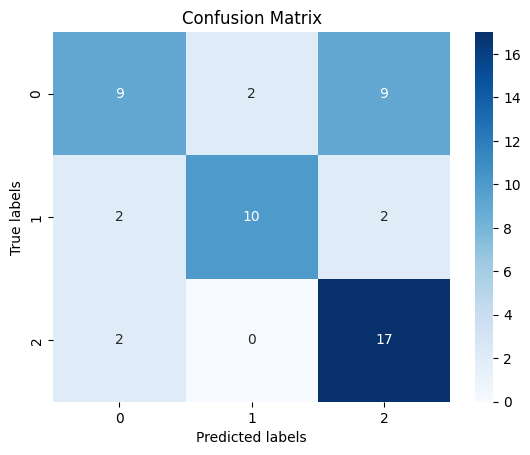

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds_eval)

# Plot confusion matrix using seaborn heatmap
classes = [0, 1, 2]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


visualisation for hate categories only

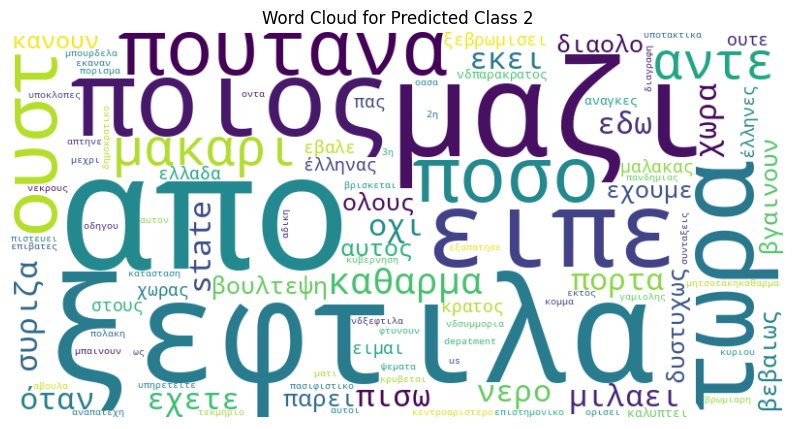

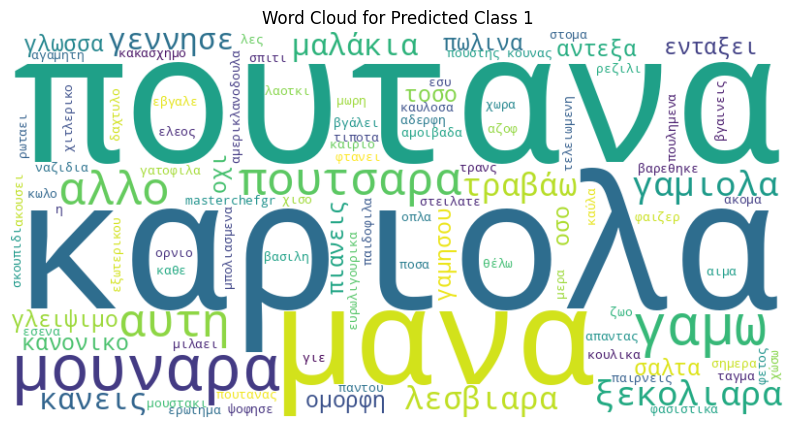

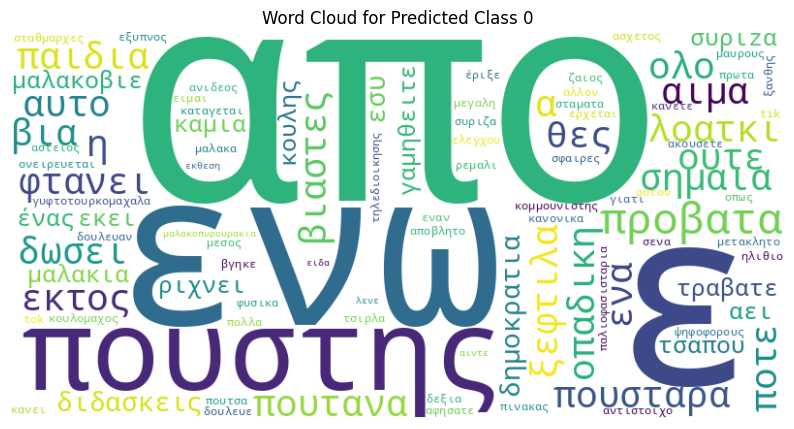

In [ ]:
# Add predicted classes to the DataFrame
df_val = pd.DataFrame({'Tweet': X_val, 'Predicted_Category': all_preds_eval})

# pre-processing
df_val['Tweet'] = df_val['Tweet'].apply(lambda x: text_processing(x))
df_val['Tweet'] = df_val['Tweet'].apply(lambda x: clean_text(x))

# Create WordClouds for each predicted class
for label in df_val['Predicted_Category'].unique():
    text = " ".join(df_val[df_val['Predicted_Category'] == label]['Tweet'])

    # Create a WordCloud for each class
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Predicted Class {label}')
    plt.axis('off')
    plt.show()

more labeled in dataset in category - xeirotera!!

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
import numpy as np


kfold = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
for i, (train_index, test_index) in enumerate(kfold.split(df_only_hate['Tweet'], df_only_hate['category'])):
        X_train, X_val, y_train, y_val = df_only_hate['Tweet'][train_index], df_only_hate['Tweet'][test_index], df_only_hate['category'][train_index], df_only_hate['category'][test_index]


# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)  # 3 classes

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model



Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.3860
              precision    recall  f1-score   support

           0       1.00      0.05      0.10        20
           1       0.00      0.00      0.00        16
           2       0.38      1.00      0.55        21

    accuracy                           0.39        57
   macro avg       0.46      0.35      0.21        57
weighted avg       0.49      0.39      0.23        57



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5 - Validation Accuracy: 0.3684
              precision    recall  f1-score   support

           0       0.35      0.80      0.48        20
           1       0.00      0.00      0.00        16
           2       0.50      0.24      0.32        21

    accuracy                           0.37        57
   macro avg       0.28      0.35      0.27        57
weighted avg       0.31      0.37      0.29        57

Epoch 3/5 - Validation Accuracy: 0.4211
              precision    recall  f1-score   support

           0       0.38      0.70      0.49        20
           1       0.30      0.19      0.23        16
           2       0.70      0.33      0.45        21

    accuracy                           0.42        57
   macro avg       0.46      0.41      0.39        57
weighted avg       0.47      0.42      0.40        57

Epoch 4/5 - Validation Accuracy: 0.4211
              precision    recall  f1-score   support

           0       0.38      0.30      0.33        20
         

## other greek dataset

In [ ]:
# PRE-PROCESSING
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import re

OGTD  = pd.read_csv('OGTDv1.csv')
OGTD = OGTD[['Tweet', 'Label']]
OGTD['Label'] = OGTD['Label'].replace('Offensive', 1)
OGTD['Label'] = OGTD['Label'].replace('Not Offensive', 0)


def clean_text(text):
    text = text.lower()
    hashtags = "#[\S]+"
    mentions = "@[\S]+"
    url = "https?://[A-z0-9_%/\-\.]+[A-z0-9_\.\-\?&=%]+"
    text = re.sub(url,"",text)
    text = re.sub(hashtags,"",text)
    text = re.sub(mentions,"",text)
    puntuations = "[\.\?!,;:]+"
    text = re.sub(puntuations,"",text)
    return text

def replaceMultiple(main, replacements, new):
    for elem in replacements:
        if elem in main:
            main = main.replace(elem, new)

    return main


def normalize(x):
    x = x.replace('ά', 'α')
    x = x.replace('έ', 'ε')
    x = x.replace('ή', 'η')
    x = replaceMultiple(x, ['ί', 'ΐ', 'ϊ'], 'ι')
    x = x.replace('ό', 'ο')
    x = replaceMultiple(x, ['ύ', 'ΰ', 'ϋ'], 'υ')
    x = x.replace('ώ', 'ω')
    return x

def remove_stopwords(text):
    stop_words = stopwords.words('greek')

    imp_words = []

    # Storing the important words
    for word in str(text).split():

        if word not in stop_words:

            # Let's Lemmatize the word as well -- to fernw stin arxiki tou morfi
#             before appending to the imp_words list.

            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word) #doesnt really work

            imp_words.append(word)

    output = " ".join(imp_words)

    return output


punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

def text_processing(text):
    text = normalize(text)  #diwxnw tonous
    text = text.lower() #ola mikra
    text = remove_punctuations(text) #diwxnw punctiations
#     text = remove_stopwords(text) #diwxnw stopwords
#     text  = " ".join([w.lemma_ for w in nlp(text)]) #lemmatization is not really working well either
    return text

OGTD['Tweet'] = OGTD['Tweet'].apply(lambda x: text_processing(x))
OGTD['Tweet'] = OGTD['Tweet'].apply(lambda x: clean_text(x))

OGTD

,Tweet,Label
0,αδιανοητη πiσω οψη απο ελληνιδα παρουσιαστρια ...,0
1,πραξικοπημα στη δικαιοσυνη οι μπολσεβικοι καιν...,0
2,αν εισαι σκορπιος εισαι η μεγαλυτερη «σκυλα» ε...,0
3,«power of lονe 2» τι να κανει και ο ίωνας ο κε...,0
4,fashion tips by beast boy αν θελετε να ειστε s...,0
...,...,...
4774,ειχε την αδερφη μου φετος και ειχε το nerve να...,0
4775,μια φορα ο βασιλης να κανει αυτο που θελει οχι...,0
4776,user ακομα μαζι μου εισαι εσυ δεν σε θελω ρε,0
4777,αχ που εισαι σαμαρα που εφυγες απ το μαξιμου π...,0


In [ ]:

OGTD

,Tweet,Label
0,αδιανοητη πiσω οψη απο ελληνιδα παρουσιαστρια ...,0
1,πραξικοπημα στη δικαιοσυνη οι μπολσεβικοι καιν...,0
2,αν εισαι σκορπιος εισαι η μεγαλυτερη «σκυλα» ε...,0
3,«power of lονe 2» τι να κανει και ο ίωνας ο κε...,0
4,fashion tips by beast boy αν θελετε να ειστε s...,0
...,...,...
4774,ειχε την αδερφη μου φετος και ειχε το nerve να...,0
4775,μια φορα ο βασιλης να κανει αυτο που θελει οχι...,0
4776,user ακομα μαζι μου εισαι εσυ δεν σε θελω ρε,0
4777,αχ που εισαι σαμαρα που εφυγες απ το μαξιμου π...,0


In [ ]:
# df['Label']=df['Label'].replace(2, 1)

## MODEL: 'nlpaueb/bert-base-greek-uncased-v1'

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


# Save the trained model
model.save_pretrained("hate_speech_model")
tokenizer.save_pretrained("hate_speech_model")

print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.8482
              precision    recall  f1-score   support

           0       0.83      0.77      0.80        44
           1       0.86      0.90      0.88        68

    accuracy                           0.85       112
   macro avg       0.84      0.83      0.84       112
weighted avg       0.85      0.85      0.85       112

Epoch 2/5 - Validation Accuracy: 0.8661
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        44
           1       0.87      0.91      0.89        68

    accuracy                           0.87       112
   macro avg       0.86      0.85      0.86       112
weighted avg       0.87      0.87      0.87       112

Epoch 3/5 - Validation Accuracy: 0.8839
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        44
           1       0.91      0.90      0.90        68

    accuracy                           0.88       112
   macro

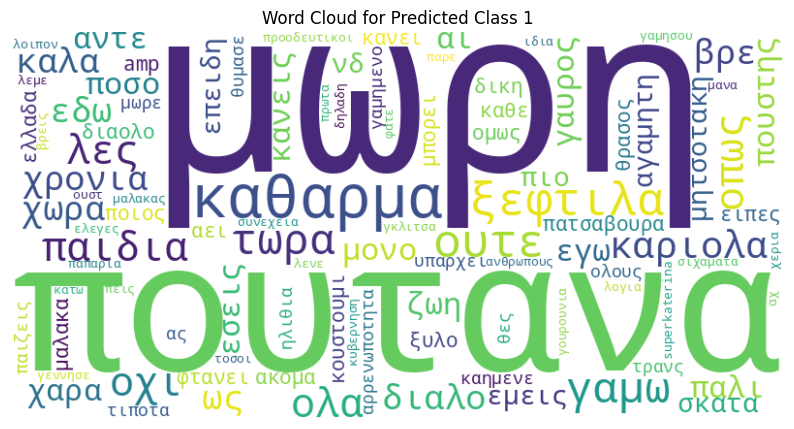

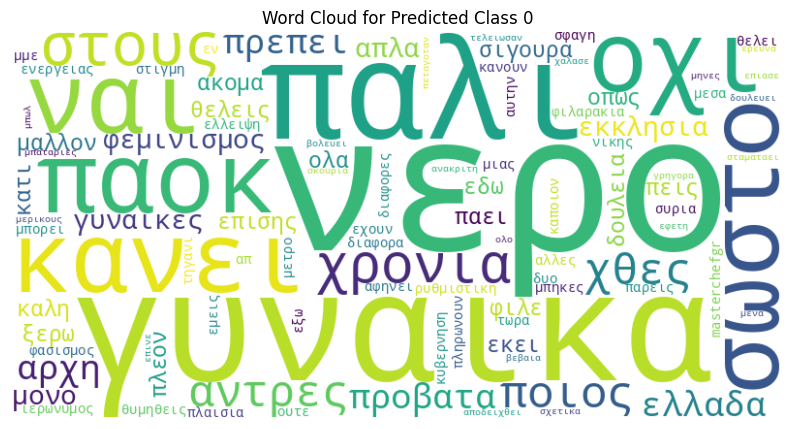

In [ ]:
# Add predicted classes to the DataFrame
df_val = pd.DataFrame({'Tweet': X_val, 'Predicted_Category': all_preds_eval})

# pre-processing
df_val['Tweet'] = df_val['Tweet'].apply(lambda x: text_processing(x))
df_val['Tweet'] = df_val['Tweet'].apply(lambda x: clean_text(x))

# Create WordClouds for each predicted class
for label in df_val['Predicted_Category'].unique():
    text = " ".join(df_val[df_val['Predicted_Category'] == label]['Tweet'])

    # Create a WordCloud for each class
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Predicted Class {label}')
    plt.axis('off')
    plt.show()

## MODEL: 'nlpaueb/bert-base-greek-uncased-v1' train on mine testing on OGTDv1 dataset

In [ ]:
# Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)


# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

#idio test set opws sto paper https://aclanthology.org/2020.lrec-1.629.pdf
X_train_GREEK_2, X_val_GREEK_2, y_train_GREEK_2, y_val_GREEK_2 = train_test_split(OGTD['Tweet'], OGTD['Label'], test_size=0.3, random_state=42)


# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val_GREEK_2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val_GREEK_2)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


print("Training complete. Model saved as 'hate_speech_model'.")


NameError: ignored

# MODEL: 'nlpaueb/bert-base-greek-uncased-v1' train on OGTD test on mine!


In [ ]:
# Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)


# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

#idio test set opws sto paper https://aclanthology.org/2020.lrec-1.629.pdf
X_train_GREEK_2, X_val_GREEK_2, y_train_GREEK_2, y_val_GREEK_2 = train_test_split(OGTD['Tweet'], OGTD['Label'], test_size=0.3, random_state=42)


# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train_GREEK_2)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train_GREEK_2)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5 #anti gia 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/5 - Validation Accuracy: 0.8214
              precision    recall  f1-score   support

           0       0.69      0.98      0.81        44
           1       0.98      0.72      0.83        68

    accuracy                           0.82       112
   macro avg       0.84      0.85      0.82       112
weighted avg       0.87      0.82      0.82       112

Epoch 2/5 - Validation Accuracy: 0.9018
              precision    recall  f1-score   support

           0       0.82      0.95      0.88        44
           1       0.97      0.87      0.91        68

    accuracy                           0.90       112
   macro avg       0.90      0.91      0.90       112
weighted avg       0.91      0.90      0.90       112

Epoch 3/5 - Validation Accuracy: 0.8929
              precision    recall  f1-score   support

           0       0.82      0.93      0.87        44
           1       0.95      0.87      0.91        68

    accuracy                           0.89       112
   macro

In [ ]:
# Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)


# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

#idio test set opws sto paper https://aclanthology.org/2020.lrec-1.629.pdf
X_train_GREEK_2, X_val_GREEK_2, y_train_GREEK_2, y_val_GREEK_2 = train_test_split(OGTD['Tweet'], OGTD['Label'], test_size=0.3, random_state=42)


# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train_GREEK_2)
val_texts = list(X_val_GREEK_2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train_GREEK_2)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val_GREEK_2)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5 #anti gia 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/5 - Validation Accuracy: 0.8501
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       988
           1       0.81      0.68      0.74       446

    accuracy                           0.85      1434
   macro avg       0.84      0.80      0.82      1434
weighted avg       0.85      0.85      0.85      1434

Epoch 2/5 - Validation Accuracy: 0.8787
              precision    recall  f1-score   support

           0       0.89      0.94      0.91       988
           1       0.85      0.74      0.79       446

    accuracy                           0.88      1434
   macro avg       0.87      0.84      0.85      1434
weighted avg       0.88      0.88      0.88      1434

Epoch 3/5 - Validation Accuracy: 0.8773
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       988
           1       0.82      0.77      0.80       446

    accuracy                           0.88      1434
   macro

# MODEL: 'nlpaueb/bert-base-greek-uncased-v1' TRAIN ON all greek data together TEST ON MINE

In [ ]:
# Renaming column 'A' to 'New_Column'
OGTD = OGTD.rename(columns={'Label': 'class'}) #change the name so i can merge the 2 datasets
OGTD

,Tweet,class
0,αδιανοητη πiσω οψη απο ελληνιδα παρουσιαστρια ...,0
1,πραξικοπημα στη δικαιοσυνη οι μπολσεβικοι καιν...,0
2,αν εισαι σκορπιος εισαι η μεγαλυτερη «σκυλα» ε...,0
3,«power of lονe 2» τι να κανει και ο ίωνας ο κε...,0
4,fashion tips by beast boy αν θελετε να ειστε s...,0
...,...,...
4774,ειχε την αδερφη μου φετος και ειχε το nerve να...,0
4775,μια φορα ο βασιλης να κανει αυτο που θελει οχι...,0
4776,user ακομα μαζι μου εισαι εσυ δεν σε θελω ρε,0
4777,αχ που εισαι σαμαρα που εφυγες απ το μαξιμου π...,0


In [ ]:
# Concatenate the DataFrames
final_merged = pd.concat([df, OGTD])
final_merged = final_merged.sample(frac=1) #SHUFFLE
final_merged.reset_index(inplace=True)
final_merged = final_merged.drop('index', axis=1)
final_merged


,Tweet,class
0,user ποσο καραγκιοζης μπορει να εισαι με αυτοκ...,0
1,ουξω κλωσσες shoppingstar,0
2,Η ίωση από μόνη της όχι. Αλλά ο επίμονος ή συ...,0
3,ολοι εσεις οι εξυπνοι οι διαφορετικου επιπεδου...,1
4,user να εισαι σιγουρος οτι σε νιωθουν παρα πολ...,0
...,...,...
5330,giatinparea οι θεατες τετοιων εκπομπων ψηφισαν...,0
5331,“επανασταση ειναι να εισαι σωστος ανθρωπος σ’ε...,0
5332,και μην ξεχνατε σας αγαπω paris shoppingstar,0
5333,user ναι ρε συ η αδερφη μου την ανιψια μου την...,0


In [ ]:
len(final_merged[final_merged['class']==1])

1670

In [ ]:
len(final_merged[final_merged['class']==0])

3665

In [ ]:
1670/5335

0.31302717900656046

In [ ]:
X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(final_merged['Tweet'], final_merged['class'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)


merged me ellhniko!!!

In [ ]:
import pandas as pd

def remove_common_values(series_a, series_b):
    common_values = set(series_a).intersection(set(series_b))

    # Remove rows with common values from series_a
    series_a = series_a[~series_a.isin(common_values)]

    return series_a

modified_series_a = remove_common_values(X_train_merged, X_val)

print("Modified series_a:")
print(modified_series_a)

Modified series_a:
3941                                user καλα εισαι ακομα
1897    κοβει το μαγειρικο σου ματι μογγολε τασο γιαυτ...
2229    user για κατι τετοιους δεν επεμβαινει καμια δι...
4299    ακομη δε χωρισε η κατερινα και να φλεταρει με ...
2868    σας ευχαριστω απο καρδιας μας ειπε ο user κλει...
                              ...                        
3092    ρε ποιον δουλευετε η ζενια οταν ειχε πρωτομπει...
3772    ρε πασχο σοβαρα τωρα εισαι ενα βημα απο την εκ...
5191    πηγα σε ενα φαρμακειο σημερα κ ενα ζαβο ηθελε ...
5226    ρωταει η αλλη στο poweroflovegr αν ο αλλος εκλ...
860     user γενικα οι γυναικες το δυναμικο κ το ομορφ...
Name: Tweet, Length: 4178, dtype: object


In [ ]:
import pandas as pd

def keep_common_indices(series1, series2):
    common_indices = series1.index.intersection(series2.index)

    series1_common = series1.loc[common_indices]
    series2_common = series2.loc[common_indices]

    return series1_common, series2_common


common_series_a, common_series_b = keep_common_indices(modified_series_a, y_train_merged)

print("Common Series_a:")
print(common_series_a)

print("\nCommon Series_b:")
print(common_series_b)

Common Series_a:
3941                                user καλα εισαι ακομα
1897    κοβει το μαγειρικο σου ματι μογγολε τασο γιαυτ...
2229    user για κατι τετοιους δεν επεμβαινει καμια δι...
4299    ακομη δε χωρισε η κατερινα και να φλεταρει με ...
2868    σας ευχαριστω απο καρδιας μας ειπε ο user κλει...
                              ...                        
3092    ρε ποιον δουλευετε η ζενια οταν ειχε πρωτομπει...
3772    ρε πασχο σοβαρα τωρα εισαι ενα βημα απο την εκ...
5191    πηγα σε ενα φαρμακειο σημερα κ ενα ζαβο ηθελε ...
5226    ρωταει η αλλη στο poweroflovegr αν ο αλλος εκλ...
860     user γενικα οι γυναικες το δυναμικο κ το ομορφ...
Name: Tweet, Length: 4178, dtype: object

Common Series_b:
3941    0
1897    0
2229    1
4299    0
2868    0
       ..
3092    1
3772    0
5191    1
5226    0
860     1
Name: class, Length: 4178, dtype: int64


merged me ogtd

In [ ]:
X_train_GREEK_2, X_val_GREEK_2, y_train_GREEK_2, y_val_GREEK_2 = train_test_split(OGTD['Tweet'], OGTD['class'], test_size=0.3, random_state=42)

In [ ]:
import pandas as pd

def remove_common_values(series_a, series_b):
    common_values = set(series_a).intersection(set(series_b))
    # Remove rows with common values from series_a
    series_a = series_a[~series_a.isin(common_values)]
    return series_a

modified_series_OGTD = remove_common_values(X_train_merged, X_val_GREEK_2)

# print("Modified series_a:")
# print(modified_series_a)

import pandas as pd

def keep_common_indices(series1, series2):
    common_indices = series1.index.intersection(series2.index)
    series1_common = series1.loc[common_indices]
    series2_common = series2.loc[common_indices]
    return series1_common, series2_common


common_series_X_OGTD, common_series_Y_OGTD = keep_common_indices(modified_series_OGTD, y_train_merged)

print("Common Series_OGTD:")
print(common_series_X_OGTD)

print("\nCommon Series_OGTD:")
print(common_series_Y_OGTD)


Common Series_OGTD:
3941                                user καλα εισαι ακομα
1897    κοβει το μαγειρικο σου ματι μογγολε τασο γιαυτ...
2229    user για κατι τετοιους δεν επεμβαινει καμια δι...
4299    ακομη δε χωρισε η κατερινα και να φλεταρει με ...
2868    σας ευχαριστω απο καρδιας μας ειπε ο user κλει...
                              ...                        
3171    user εισαι πολυ μαλακισμενο για να καταναλωσω ...
3444    ο παυλος εχει κατι βαρβαρο απολιτιστο ωμο επισ...
466                           user όσο ζεις εισαι τυχερος
3092    ρε ποιον δουλευετε η ζενια οταν ειχε πρωτομπει...
5191    πηγα σε ενα φαρμακειο σημερα κ ενα ζαβο ηθελε ...
Name: Tweet, Length: 3130, dtype: object

Common Series_OGTD:
3941    0
1897    0
2229    1
4299    0
2868    0
       ..
3171    1
3444    1
466     0
3092    1
5191    1
Name: class, Length: 3130, dtype: int64


In [ ]:
# Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)


# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# # Split the dataset into training and validation sets
# # train it to the merged data
# X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(final_merged['Tweet'], final_merged['class'], test_size=0.2, random_state=42)

# # test it on MY dataset
# X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(common_series_a)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(common_series_b)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5 #anti gia 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


print("Training complete. Model saved as 'hate_speech_model'.")


(…)ed-v1/resolve/main/tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

(…)-greek-uncased-v1/resolve/main/vocab.txt:   0%|          | 0.00/530k [00:00<?, ?B/s]

(…)-v1/resolve/main/special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

(…)reek-uncased-v1/resolve/main/config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/5 - Validation Accuracy: 0.9196
              precision    recall  f1-score   support

           0       0.95      0.84      0.89        44
           1       0.90      0.97      0.94        68

    accuracy                           0.92       112
   macro avg       0.93      0.91      0.91       112
weighted avg       0.92      0.92      0.92       112

Epoch 2/5 - Validation Accuracy: 0.9375
              precision    recall  f1-score   support

           0       0.95      0.89      0.92        44
           1       0.93      0.97      0.95        68

    accuracy                           0.94       112
   macro avg       0.94      0.93      0.93       112
weighted avg       0.94      0.94      0.94       112

Epoch 3/5 - Validation Accuracy: 0.9286
              precision    recall  f1-score   support

           0       0.95      0.86      0.90        44
           1       0.92      0.97      0.94        68

    accuracy                           0.93       112
   macro

In [ ]:
# Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)


# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
# train it to the merged data
X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(final_merged['Tweet'], final_merged['class'], test_size=0.2, random_state=42)

# test it on MY dataset
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train_merged)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train_merged)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5 #anti gia 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/5 - Validation Accuracy: 0.9286
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        44
           1       0.93      0.96      0.94        68

    accuracy                           0.93       112
   macro avg       0.93      0.92      0.92       112
weighted avg       0.93      0.93      0.93       112

Epoch 2/5 - Validation Accuracy: 0.9643
              precision    recall  f1-score   support

           0       0.98      0.93      0.95        44
           1       0.96      0.99      0.97        68

    accuracy                           0.96       112
   macro avg       0.97      0.96      0.96       112
weighted avg       0.96      0.96      0.96       112

Epoch 3/5 - Validation Accuracy: 0.9732
              precision    recall  f1-score   support

           0       0.98      0.95      0.97        44
           1       0.97      0.99      0.98        68

    accuracy                           0.97       112
   macro

# MODEL: 'nlpaueb/bert-base-greek-uncased-v1' TRAIN ON all greek data together TEST ON OGTD

In [ ]:
# Split the dataset into training and validation sets
# X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)


# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# # Split the dataset into training and validation sets
# # train it to the merged data
# X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(final_merged['Tweet'], final_merged['class'], test_size=0.2, random_state=42)

# # test it on OGTD dataset
# X_train_GREEK_2, X_val_GREEK_2, y_train_GREEK_2, y_val_GREEK_2 = train_test_split(OGTD['Tweet'], OGTD['class'], test_size=0.3, random_state=42)


# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(common_series_X_OGTD)
val_texts = list(X_val_GREEK_2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(common_series_Y_OGTD)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val_GREEK_2)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5 #anti gia 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Epoch 1/5 - Validation Accuracy: 0.8431
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       988
           1       0.76      0.72      0.74       446

    accuracy                           0.84      1434
   macro avg       0.82      0.81      0.81      1434
weighted avg       0.84      0.84      0.84      1434

Epoch 2/5 - Validation Accuracy: 0.8654
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       988
           1       0.79      0.76      0.78       446

    accuracy                           0.87      1434
   macro avg       0.85      0.84      0.84      1434
weighted avg       0.86      0.87      0.86      1434

Epoch 3/5 - Validation Accuracy: 0.8717
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       988
           1       0.78      0.82      0.80       446

    accuracy                           0.87      1434
   macro

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report


In [ ]:
all_preds = np.array(all_preds)

In [ ]:
conf_matrix = confusion_matrix(all_labels, all_preds)
print(conf_matrix)


[[510  87]
 [ 84 157]]


In [ ]:
class_report = classification_report(all_labels, all_preds)


In [ ]:
class_report

'              precision    recall  f1-score   support\n\n           0       0.86      0.85      0.86       597\n           1       0.64      0.65      0.65       241\n\n    accuracy                           0.80       838\n   macro avg       0.75      0.75      0.75       838\nweighted avg       0.80      0.80      0.80       838\n'

precision    recall  f1-score   support

           0       0.86      0.85      0.86       597
           1       0.64      0.65      0.65       241

    accuracy                           0.80       838
   macro avg       0.75      0.75      0.75       838
weighted avg       0.80      0.80      0.80       838

## OGTD

In [ ]:
# PRE-PROCESSING
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import spacy
import re

In [ ]:
OGTD  = pd.read_csv('OGTDv1.csv')
OGTD = OGTD[['Tweet', 'Label']]
OGTD

OGTD['Label'] = OGTD['Label'].replace('Offensive', 1)
OGTD['Label'] = OGTD['Label'].replace('Not Offensive', 0)




In [ ]:
def clean_text(text):
    text = text.lower()
    hashtags = "#[\S]+"
    mentions = "@[\S]+"
    url = "https?://[A-z0-9_%/\-\.]+[A-z0-9_\.\-\?&=%]+"
    text = re.sub(url,"",text)
    text = re.sub(hashtags,"",text)
    text = re.sub(mentions,"",text)
    puntuations = "[\.\?!,;:]+"
    text = re.sub(puntuations,"",text)
    return text

def replaceMultiple(main, replacements, new):
    for elem in replacements:
        if elem in main:
            main = main.replace(elem, new)

    return main


def normalize(x):
    x = x.replace('ά', 'α')
    x = x.replace('έ', 'ε')
    x = x.replace('ή', 'η')
    x = replaceMultiple(x, ['ί', 'ΐ', 'ϊ'], 'ι')
    x = x.replace('ό', 'ο')
    x = replaceMultiple(x, ['ύ', 'ΰ', 'ϋ'], 'υ')
    x = x.replace('ώ', 'ω')
    return x

def remove_stopwords(text):
    stop_words = stopwords.words('greek')

    imp_words = []

    # Storing the important words
    for word in str(text).split():

        if word not in stop_words:

            # Let's Lemmatize the word as well -- to fernw stin arxiki tou morfi
#             before appending to the imp_words list.

            lemmatizer = WordNetLemmatizer()
            lemmatizer.lemmatize(word) #doesnt really work

            imp_words.append(word)

    output = " ".join(imp_words)

    return output


punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)

def text_processing(text):
    text = normalize(text)  #diwxnw tonous
    text = text.lower() #ola mikra
    text = remove_punctuations(text) #diwxnw punctiations
#     text = remove_stopwords(text) #diwxnw stopwords
#     text  = " ".join([w.lemma_ for w in nlp(text)]) #lemmatization is not really working well either
    return text



In [ ]:
OGTD['Tweet'] = OGTD['Tweet'].apply(lambda x: text_processing(x))
OGTD['Tweet'] = OGTD['Tweet'].apply(lambda x: clean_text(x))


In [ ]:
OGTD

,Tweet,Label
0,αδιανοητη πiσω οψη απο ελληνιδα παρουσιαστρια ...,0
1,πραξικοπημα στη δικαιοσυνη οι μπολσεβικοι καιν...,0
2,αν εισαι σκορπιος εισαι η μεγαλυτερη «σκυλα» ε...,0
3,«power of lονe 2» τι να κανει και ο ίωνας ο κε...,0
4,fashion tips by beast boy αν θελετε να ειστε s...,0
...,...,...
4774,ειχε την αδερφη μου φετος και ειχε το nerve να...,0
4775,μια φορα ο βασιλης να κανει αυτο που θελει οχι...,0
4776,user ακομα μαζι μου εισαι εσυ δεν σε θελω ρε,0
4777,αχ που εισαι σαμαρα που εφυγες απ το μαξιμου π...,0


In [ ]:
df['Tweet'] = df['Tweet'].apply(lambda x: text_processing(x))
df['Tweet'] = df['Tweet'].apply(lambda x: clean_text(x))

In [ ]:
df

,Tweet,Label
0,ας κανουν οτι θελουν δε με αφορα αλλα η ακρι...,0
1,η απορια της ημερας\n\nγιατι σε φωτογραφια που...,0
2,ρε κοψτε την συνδεση με τον βλακα καραγιαννη ε...,1
3,πολυ βολικο παντως που λιγο πριν το τροχαιο μι...,0
4,μονο απο τον παοκ σας πηραν μηπως σας πηραν β...,0
...,...,...
4181,καθικι γεραπετριτη\nπηγε ο τσιπρας τωρα στη λα...,1
4182,να τα πει φανερα με το ονομα του να δουμε ποι...,1
4183,χαθηκε το μορφωτικο επιπεδο και το βρηκε η σι...,1
4184,δε πατε στο διαλο που προσπαθειτε να δικαιο...,1


edw testara me to OGTF train k to diko toy test kai trexei xalia, na dokimasw training to ogtd KAI to diko m xtrain!!

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['Label'], test_size=0.2, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

# train with OGTD and X_train

x_train = pd.concat([X_train,OGTD['Tweet']])
Y_train = pd.concat([y_train,OGTD['Label']])

train_texts = list(x_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(Y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


# Save the trained model
model.save_pretrained("hate_speech_model")
tokenizer.save_pretrained("hate_speech_model")

print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.7124
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       597
           1       0.00      0.00      0.00       241

    accuracy                           0.71       838
   macro avg       0.36      0.50      0.42       838
weighted avg       0.51      0.71      0.59       838



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5 - Validation Accuracy: 0.7124
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       597
           1       0.00      0.00      0.00       241

    accuracy                           0.71       838
   macro avg       0.36      0.50      0.42       838
weighted avg       0.51      0.71      0.59       838



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/5 - Validation Accuracy: 0.7124
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       597
           1       0.00      0.00      0.00       241

    accuracy                           0.71       838
   macro avg       0.36      0.50      0.42       838
weighted avg       0.51      0.71      0.59       838



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4/5 - Validation Accuracy: 0.7124
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       597
           1       0.00      0.00      0.00       241

    accuracy                           0.71       838
   macro avg       0.36      0.50      0.42       838
weighted avg       0.51      0.71      0.59       838



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/5 - Validation Accuracy: 0.7124
              precision    recall  f1-score   support

           0       0.71      1.00      0.83       597
           1       0.00      0.00      0.00       241

    accuracy                           0.71       838
   macro avg       0.36      0.50      0.42       838
weighted avg       0.51      0.71      0.59       838



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training complete. Model saved as 'hate_speech_model'.


## MODEL: "xlm-roberta-base"

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model

# Save the trained model
model.save_pretrained("hate_speech_model2")
tokenizer.save_pretrained("hate_speech_model21")

print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.3929
              precision    recall  f1-score   support

           0       0.39      1.00      0.56        44
           1       0.00      0.00      0.00        68

    accuracy                           0.39       112
   macro avg       0.20      0.50      0.28       112
weighted avg       0.15      0.39      0.22       112



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5 - Validation Accuracy: 0.4018
              precision    recall  f1-score   support

           0       0.40      1.00      0.57        44
           1       1.00      0.01      0.03        68

    accuracy                           0.40       112
   macro avg       0.70      0.51      0.30       112
weighted avg       0.76      0.40      0.24       112

Epoch 3/5 - Validation Accuracy: 0.7768
              precision    recall  f1-score   support

           0       0.65      0.93      0.77        44
           1       0.94      0.68      0.79        68

    accuracy                           0.78       112
   macro avg       0.79      0.80      0.78       112
weighted avg       0.83      0.78      0.78       112

Epoch 4/5 - Validation Accuracy: 0.8750
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        44
           1       0.94      0.85      0.89        68

    accuracy                           0.88       112
   macro

## MODEL: "xlm-roberta-base" train on ALL test on my data

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model

# Save the trained model
model.save_pretrained("hate_speech_model2")
tokenizer.save_pretrained("hate_speech_model21")

print("Training complete. Model saved as 'hate_speech_model'.")


## MODEL: "xlm-roberta-base" train on english dataset test on my data

In [ ]:
# LOADING THE DATA

en_dataset  = pd.read_csv('en_hate_off_dataset_davidson.csv')

final_en = en_dataset[['tweet', 'class']]

# 0 - hate speech
# 1 - offensive language
# 2 - neither

import re

def remove_usernames(tweet):
    tweet = re.sub('@[^\s]+','',tweet) #remove usernames
    return tweet

def remove_links(tweet):
    tweet = re.sub('http[^\s]+','',tweet) #remove links
    return tweet

#new column with tweets without links or tags so we can extract the same content
final_en['tweet'] = final_en['tweet'].apply(remove_usernames)
final_en['tweet'] = final_en['tweet'].apply(remove_links)

final_en = final_en[['tweet', 'class']]

final_en['class'] = final_en['class'].replace(0,1) #hate offensiev =1
final_en['class'] = final_en['class'].replace(2, 0) #xgboost needs continuous numberS of classes / neutral =0
final_en

<ipython-input-5-166702942db0>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_en['tweet'] = final_en['tweet'].apply(remove_usernames)
<ipython-input-5-166702942db0>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_en['tweet'] = final_en['tweet'].apply(remove_links)


,tweet,class
0,!!! RT As a woman you shouldn't complain abou...,0
1,!!!!! RT boy dats cold...tyga dwn bad for cuf...,1
2,!!!!!!! RT Dawg!!!! RT You ever fuck a bitch...,1
3,!!!!!!!!! RT she look like a tranny,1
4,!!!!!!!!!!!!! RT The shit you hear about me m...,1
...,...,...
24778,you's a muthaf***in lie &#8220; right! His T...,1
24779,"you've gone and broke the wrong heart baby, an...",0
24780,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,youu got wild bitches tellin you lies,1


## Free Memory Manually:
Ensure you're deleting tensors or models that are no longer in use during the training loop. Use torch.cuda.empty_cache() to release cached memory.

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
X_train_en, X_val_en, y_train_en, y_val_en = train_test_split(final_en['tweet'], final_en['class'], test_size=0.2, random_state=42)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

X_train_en, X_val_en, y_train_en, y_val_en = train_test_split(final_en['tweet'], final_en['class'], test_size=0.1, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_val_en)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_val_en)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.6071
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        44
           1       0.61      1.00      0.76        68

    accuracy                           0.61       112
   macro avg       0.30      0.50      0.38       112
weighted avg       0.37      0.61      0.46       112



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5 - Validation Accuracy: 0.6696
              precision    recall  f1-score   support

           0       0.56      0.70      0.63        44
           1       0.77      0.65      0.70        68

    accuracy                           0.67       112
   macro avg       0.67      0.68      0.67       112
weighted avg       0.69      0.67      0.67       112

Epoch 3/5 - Validation Accuracy: 0.5268
              precision    recall  f1-score   support

           0       0.45      0.91      0.60        44
           1       0.83      0.28      0.42        68

    accuracy                           0.53       112
   macro avg       0.64      0.59      0.51       112
weighted avg       0.68      0.53      0.49       112

Epoch 4/5 - Validation Accuracy: 0.6071
              precision    recall  f1-score   support

           0       0.50      0.82      0.62        44
           1       0.80      0.47      0.59        68

    accuracy                           0.61       112
   macro

## MODEL: "xlm-roberta-base" train on english dataset test on OGTD

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
# test on OGTD
X_train, X_val, y_train, y_val = train_test_split(OGTD['Tweet'], OGTD['Label'], test_size=0.2, random_state=42)

# TRAIN ON ENGLISH
X_train_en, X_val_en, y_train_en, y_val_en = train_test_split(final_en['tweet'], final_en['class'], test_size=0.1, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_val_en)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_val_en)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.3285
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       642
           1       0.33      1.00      0.49       314

    accuracy                           0.33       956
   macro avg       0.16      0.50      0.25       956
weighted avg       0.11      0.33      0.16       956



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/5 - Validation Accuracy: 0.3285
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       642
           1       0.33      1.00      0.49       314

    accuracy                           0.33       956
   macro avg       0.16      0.50      0.25       956
weighted avg       0.11      0.33      0.16       956



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3/5 - Validation Accuracy: 0.5805
              precision    recall  f1-score   support

           0       0.70      0.66      0.68       642
           1       0.37      0.41      0.39       314

    accuracy                           0.58       956
   macro avg       0.54      0.54      0.54       956
weighted avg       0.59      0.58      0.59       956

Epoch 4/5 - Validation Accuracy: 0.6109
              precision    recall  f1-score   support

           0       0.71      0.72      0.71       642
           1       0.41      0.39      0.40       314

    accuracy                           0.61       956
   macro avg       0.56      0.56      0.56       956
weighted avg       0.61      0.61      0.61       956

Epoch 5/5 - Validation Accuracy: 0.6109
              precision    recall  f1-score   support

           0       0.72      0.68      0.70       642
           1       0.42      0.47      0.44       314

    accuracy                           0.61       956
   macro

## OR

USE THE TRAINED MODEL TO OTHER TEST SET ANG GIVES IMMMEDATELY THE RESULT WITH THIS CODE: - trained on the english dataset/ tested on my dataset

In [ ]:
# change the test dataset
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Assuming you have a separate test set named 'test_data' and 'test_labels'
test_texts = list(X_val)  # Assuming 'test_data' contains text data

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_labels = np.array(y_val)  # Assuming 'test_labels' contains corresponding labels

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

# Create a data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Set the model to evaluation mode
model.eval()

# For making predictions on the test dataset
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate test metrics
test_accuracy = np.mean(np.array(all_test_preds) == np.array(all_test_labels))
print(f"Test Accuracy: {test_accuracy:.4f}")
test_preds_eval = np.array(all_test_preds)
test_class_report = classification_report(all_test_labels, test_preds_eval)
print(test_class_report)



Test Accuracy: 0.5625
              precision    recall  f1-score   support

           0       0.47      0.95      0.63        44
           1       0.91      0.31      0.46        68

    accuracy                           0.56       112
   macro avg       0.69      0.63      0.55       112
weighted avg       0.74      0.56      0.53       112

Test Accuracy: 0.5625
              precision    recall  f1-score   support

           0       0.47      0.95      0.63        44
           1       0.91      0.31      0.46        68

    accuracy                           0.56       112
   macro avg       0.69      0.63      0.55       112
weighted avg       0.74      0.56      0.53       112

Test Accuracy: 0.5625
              precision    recall  f1-score   support

           0       0.47      0.95      0.63        44
           1       0.91      0.31      0.46        68

    accuracy                           0.56       112
   macro avg       0.69      0.63      0.55       112
weighted

# XLM TRAIN ALL- TEST MINE

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
# test on OGTD

X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(final_merged['Tweet'], final_merged['class'], test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train_merged)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train_merged)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model



Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.8393
              precision    recall  f1-score   support

           0       0.73      0.93      0.82        44
           1       0.95      0.78      0.85        68

    accuracy                           0.84       112
   macro avg       0.84      0.86      0.84       112
weighted avg       0.86      0.84      0.84       112

Epoch 2/5 - Validation Accuracy: 0.9464
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        44
           1       0.96      0.96      0.96        68

    accuracy                           0.95       112
   macro avg       0.94      0.94      0.94       112
weighted avg       0.95      0.95      0.95       112

Epoch 3/5 - Validation Accuracy: 0.9643
              precision    recall  f1-score   support

           0       0.93      0.98      0.96        44
           1       0.98      0.96      0.97        68

    accuracy                           0.96       112
   macro

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
# test on OGTD

# Load the pre-trained BERT model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(common_series_a)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(common_series_b)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model

(…)lm-roberta-base/resolve/main/config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

(…)ase/resolve/main/sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

(…)roberta-base/resolve/main/tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Validation Accuracy: 0.8304
              precision    recall  f1-score   support

           0       0.74      0.89      0.80        44
           1       0.92      0.79      0.85        68

    accuracy                           0.83       112
   macro avg       0.83      0.84      0.83       112
weighted avg       0.84      0.83      0.83       112

Epoch 2/5 - Validation Accuracy: 0.9107
              precision    recall  f1-score   support

           0       0.97      0.80      0.88        44
           1       0.88      0.99      0.93        68

    accuracy                           0.91       112
   macro avg       0.93      0.89      0.90       112
weighted avg       0.92      0.91      0.91       112

Epoch 3/5 - Validation Accuracy: 0.8929
              precision    recall  f1-score   support

           0       0.90      0.82      0.86        44
           1       0.89      0.94      0.91        68

    accuracy                           0.89       112
   macro

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
# test on OGTD

# Load the pre-trained BERT model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(common_series_X_OGTD)
val_texts = list(X_val_GREEK_2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(common_series_Y_OGTD)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val_GREEK_2)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Validation Accuracy: 0.6890
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       988
           1       0.00      0.00      0.00       446

    accuracy                           0.69      1434
   macro avg       0.34      0.50      0.41      1434
weighted avg       0.47      0.69      0.56      1434

Epoch 2/5 - Validation Accuracy: 0.8138
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       988
           1       0.74      0.62      0.67       446

    accuracy                           0.81      1434
   macro avg       0.79      0.76      0.77      1434
weighted avg       0.81      0.81      0.81      1434

Epoch 3/5 - Validation Accuracy: 0.8375
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       988
           1       0.83      0.60      0.70       446

    accuracy                           0.84      1434
   macro

## XLM TRAIN ALL- TEST OGTD

In [ ]:
# X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(final_merged['Tweet'], final_merged['class'], test_size=0.2, random_state=42)

# # test it on OGTD dataset
X_train_GREEK_2, X_val_GREEK_2, y_train_GREEK_2, y_val_GREEK_2 = train_test_split(OGTD['Tweet'], OGTD['class'], test_size=0.3, random_state=42)

# Assuming you have a separate test set named 'test_data' and 'test_labels'
test_texts = list(X_val_GREEK_2)  # Assuming 'test_data' contains text data

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_labels = np.array(y_val_GREEK_2)  # Assuming 'test_labels' contains corresponding labels

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

# Create a data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Set the model to evaluation mode
model.eval()

# For making predictions on the test dataset
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate test metrics
test_accuracy = np.mean(np.array(all_test_preds) == np.array(all_test_labels))
print(f"Test Accuracy: {test_accuracy:.4f}")
test_preds_eval = np.array(all_test_preds)
test_class_report = classification_report(all_test_labels, test_preds_eval)
print(test_class_report)



Test Accuracy: 0.9184
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       988
           1       0.87      0.87      0.87       446

    accuracy                           0.92      1434
   macro avg       0.91      0.90      0.90      1434
weighted avg       0.92      0.92      0.92      1434



## MODEL: bert-base-multilingual-cased

In [ ]:


# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model


# Save the trained model
model.save_pretrained("hate_speech_model")
tokenizer.save_pretrained("hate_speech_model")

print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Validation Accuracy: 0.6875
              precision    recall  f1-score   support

           0       0.56      0.98      0.71        44
           1       0.97      0.50      0.66        68

    accuracy                           0.69       112
   macro avg       0.76      0.74      0.69       112
weighted avg       0.81      0.69      0.68       112

Epoch 2/5 - Validation Accuracy: 0.6696
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        44
           1       1.00      0.46      0.63        68

    accuracy                           0.67       112
   macro avg       0.77      0.73      0.67       112
weighted avg       0.82      0.67      0.66       112

Epoch 3/5 - Validation Accuracy: 0.8929
              precision    recall  f1-score   support

           0       0.81      0.95      0.88        44
           1       0.97      0.85      0.91        68

    accuracy                           0.89       112
   macro

# MODEL: bert-base-multilingual-cased train on mine test on OGTD

In [ ]:
# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

#idio test set opws sto paper https://aclanthology.org/2020.lrec-1.629.pdf
X_train_GREEK_2, X_val_GREEK_2, y_train_GREEK_2, y_val_GREEK_2 = train_test_split(OGTD['Tweet'], OGTD['Label'], test_size=0.3, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val_GREEK_2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val_GREEK_2)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Validation Accuracy: 0.5774
              precision    recall  f1-score   support

           0       0.78      0.54      0.64       988
           1       0.39      0.67      0.49       446

    accuracy                           0.58      1434
   macro avg       0.59      0.60      0.57      1434
weighted avg       0.66      0.58      0.59      1434

Epoch 2/5 - Validation Accuracy: 0.7015
              precision    recall  f1-score   support

           0       0.74      0.88      0.80       988
           1       0.54      0.31      0.39       446

    accuracy                           0.70      1434
   macro avg       0.64      0.59      0.60      1434
weighted avg       0.67      0.70      0.67      1434

Epoch 3/5 - Validation Accuracy: 0.5481
              precision    recall  f1-score   support

           0       0.84      0.42      0.56       988
           1       0.39      0.83      0.53       446

    accuracy                           0.55      1434
   macro

# MODEL: bert-base-multilingual-cased train ALL test on OGTD

In [ ]:
# X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(final_merged['Tweet'], final_merged['class'], test_size=0.2, random_state=42)

# # test it on OGTD dataset
# X_train_GREEK_2, X_val_GREEK_2, y_train_GREEK_2, y_val_GREEK_2 = train_test_split(OGTD['Tweet'], OGTD['class'], test_size=0.3, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(common_series_X_OGTD)
val_texts = list(X_val_GREEK_2)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(common_series_Y_OGTD)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val_GREEK_2)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.7036
              precision    recall  f1-score   support

           0       0.70      1.00      0.82       988
           1       0.89      0.05      0.10       446

    accuracy                           0.70      1434
   macro avg       0.79      0.53      0.46      1434
weighted avg       0.76      0.70      0.60      1434

Epoch 2/5 - Validation Accuracy: 0.8556
              precision    recall  f1-score   support

           0       0.85      0.96      0.90       988
           1       0.88      0.62      0.73       446

    accuracy                           0.86      1434
   macro avg       0.86      0.79      0.81      1434
weighted avg       0.86      0.86      0.85      1434

Epoch 3/5 - Validation Accuracy: 0.9010
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       988
           1       0.89      0.78      0.83       446

    accuracy                           0.90      1434
   macro

# MODEL: bert-base-multilingual-cased train ALL test on mine

In [ ]:
# X_train_merged, X_val_merged, y_train_merged, y_val_merged = train_test_split(final_merged['Tweet'], final_merged['class'], test_size=0.2, random_state=42)

# # test it on OGTD dataset
# X_train_GREEK_2, X_val_GREEK_2, y_train_GREEK_2, y_val_GREEK_2 = train_test_split(OGTD['Tweet'], OGTD['class'], test_size=0.3, random_state=42)

# Load the pre-trained BERT model and tokenizer
model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(common_series_a)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset( torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(common_series_b)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model

(…)cased/resolve/main/tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

(…)ultilingual-cased/resolve/main/vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

(…)ingual-cased/resolve/main/tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

(…)tilingual-cased/resolve/main/config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 - Validation Accuracy: 0.7054
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        44
           1       1.00      0.51      0.68        68

    accuracy                           0.71       112
   macro avg       0.79      0.76      0.70       112
weighted avg       0.83      0.71      0.70       112

Epoch 2/5 - Validation Accuracy: 0.9107
              precision    recall  f1-score   support

           0       0.90      0.86      0.88        44
           1       0.91      0.94      0.93        68

    accuracy                           0.91       112
   macro avg       0.91      0.90      0.91       112
weighted avg       0.91      0.91      0.91       112

Epoch 3/5 - Validation Accuracy: 0.8929
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        44
           1       0.92      0.90      0.91        68

    accuracy                           0.89       112
   macro

In [ ]:
# # change the test dataset
# X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Assuming you have a separate test set named 'test_data' and 'test_labels'
test_texts = list(X_val)  # Assuming 'test_data' contains text data

# Tokenize the test data
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_labels = np.array(y_val)  # Assuming 'test_labels' contains corresponding labels

test_dataset = TensorDataset(torch.tensor(test_encodings['input_ids']),
                             torch.tensor(test_encodings['attention_mask']),
                             torch.tensor(test_labels))

# Create a data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=batch_size)


# Set the model to evaluation mode
model.eval()

# For making predictions on the test dataset
all_test_preds = []
all_test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_test_preds.extend(preds.cpu().numpy())
        all_test_labels.extend(labels.cpu().numpy())

# Calculate test metrics
test_accuracy = np.mean(np.array(all_test_preds) == np.array(all_test_labels))
print(f"Test Accuracy: {test_accuracy:.4f}")
test_preds_eval = np.array(all_test_preds)
test_class_report = classification_report(all_test_labels, test_preds_eval)
print(test_class_report)

Test Accuracy: 0.9821
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        44
           1       0.99      0.99      0.99        68

    accuracy                           0.98       112
   macro avg       0.98      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112



## MODEL: MODEL: "xlm-roberta-base" with weights

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Load the pre-trained XLM-RoBERTa model and tokenizer
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Calculate class weights to handle data imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Create data loaders with class weights
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 5

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        # Apply class weights to the loss
        weighted_loss = (loss * class_weights[labels]).mean()
        weighted_loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)
# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model

# Save the trained model
model.save_pretrained("hate_speech_model2")
tokenizer.save_pretrained("hate_speech_model21")

print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5 - Validation Accuracy: 0.6250
              precision    recall  f1-score   support

           0       0.51      0.95      0.67        44
           1       0.93      0.41      0.57        68

    accuracy                           0.62       112
   macro avg       0.72      0.68      0.62       112
weighted avg       0.77      0.62      0.61       112

Epoch 2/5 - Validation Accuracy: 0.5179
              precision    recall  f1-score   support

           0       0.45      0.95      0.61        44
           1       0.89      0.24      0.37        68

    accuracy                           0.52       112
   macro avg       0.67      0.59      0.49       112
weighted avg       0.72      0.52      0.47       112

Epoch 3/5 - Validation Accuracy: 0.7857
              precision    recall  f1-score   support

           0       0.68      0.86      0.76        44
           1       0.89      0.74      0.81        68

    accuracy                           0.79       112
   macro

In [ ]:
all_preds = np.array(all_preds)
class_report = classification_report(all_labels, all_preds)
print(class_report)

              precision    recall  f1-score   support

           0       0.71      1.00      0.83       597
           1       0.00      0.00      0.00       241

    accuracy                           0.71       838
   macro avg       0.36      0.50      0.42       838
weighted avg       0.51      0.71      0.59       838



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## MODEL: "nlpaueb/bert-base-greek-uncased-v1" with weights

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Define your labeled dataset (X, y)
# X should contain the text data, and y should contain the corresponding labels (0 for non-hate, 1 for hate)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(df['Tweet'], df['class'], test_size=0.2, random_state=42)

# Load the pre-trained XLM-RoBERTa model and tokenizer
model_name = "nlpaueb/bert-base-greek-uncased-v1"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)  # 2 classes: non-hate and hate

# Tokenize the input text and convert to PyTorch tensors
def tokenize_text(text):
    tokens = tokenizer.encode_plus(text, padding='max_length', max_length=256, truncation=True, return_tensors='pt')
    return tokens

train_texts = list(X_train)
val_texts = list(X_val)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
num_examples = len(train_encodings['input_ids'])

train_dataset = TensorDataset(torch.tensor(train_encodings['input_ids']), torch.tensor(train_encodings['attention_mask']), torch.tensor(np.array(y_train)))
val_dataset = TensorDataset(torch.tensor(val_encodings['input_ids']), torch.tensor(val_encodings['attention_mask']), torch.tensor(np.array(y_val)))

# Calculate class weights to handle data imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Create data loaders with class weights
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size)#, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define optimizer and training parameters
optimizer = AdamW(model.parameters(), lr=1e-5)
num_epochs = 10

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        # Apply class weights to the loss
        weighted_loss = (loss * class_weights[labels]).mean()
        weighted_loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate validation metrics
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Epoch {epoch + 1}/{num_epochs} - Validation Accuracy: {accuracy:.4f}")
    all_preds_eval = np.array(all_preds)
    class_report = classification_report(all_labels, all_preds_eval)
    print(class_report)

# Evaluate the model on your test dataset and save it for later use
# Make predictions on the test dataset using the trained model

# Save the trained model
model.save_pretrained("hate_speech_model2")
tokenizer.save_pretrained("hate_speech_model21")

print("Training complete. Model saved as 'hate_speech_model'.")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/bert-base-greek-uncased-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10 - Validation Accuracy: 0.7321
              precision    recall  f1-score   support

           0       0.60      0.93      0.73        44
           1       0.93      0.60      0.73        68

    accuracy                           0.73       112
   macro avg       0.77      0.77      0.73       112
weighted avg       0.80      0.73      0.73       112

Epoch 2/10 - Validation Accuracy: 0.8839
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        44
           1       0.92      0.88      0.90        68

    accuracy                           0.88       112
   macro avg       0.88      0.88      0.88       112
weighted avg       0.89      0.88      0.88       112

Epoch 3/10 - Validation Accuracy: 0.9018
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        44
           1       0.95      0.88      0.92        68

    accuracy                           0.90       112
   ma

In [ ]:
all_preds_eval = np.array(all_preds)
class_report = classification_report(all_labels, all_preds_eval)
print(class_report)


              precision    recall  f1-score   support

           0       0.93      0.93      0.93        44
           1       0.96      0.96      0.96        68

    accuracy                           0.95       112
   macro avg       0.94      0.94      0.94       112
weighted avg       0.95      0.95      0.95       112



In [ ]:
df['Label'].value_counts()

0    2922
1    1264
Name: Label, dtype: int64